In [15]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [16]:
# arguments
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.5

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [17]:
# construct dataset
data_transforms = transforms.Compose([transforms.RandomCrop(size=28, padding=2),
                                      transforms.ToTensor()])
# total train set
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# random omit one digit train set
omit_digit = random.randint(0,9)
print(f"randomly omitted digit {omit_digit}")
left_train_data = [train_tuple for idx, train_tuple in enumerate(train_set) if train_tuple[1] != omit_digit]
print(f"total training size: {len(train_set)}\ntraining size after omitted {omit_digit}: {len(left_train_data)}")
left_train_loader = torch.utils.data.DataLoader(left_train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# total test set
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True,
                 transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=VAL_BATCH_SIZE, shuffle=True)

# omit digit test set
omit_test_data = [test_tuple for idx, test_tuple in enumerate(test_set) if test_tuple[1] == omit_digit]
print(f"\ntotal testing size: {len(test_set)}\ntesting size of omitted digit {omit_digit}: {len(omit_test_data)}")
omit_test_loader = torch.utils.data.DataLoader(omit_test_data, batch_size=VAL_BATCH_SIZE, shuffle=True)

randomly omitted digit 1
total training size: 60000
training size after omitted 1: 53258

total testing size: 10000
testing size of omitted digit 1: 1135


### Check Images

check left training images after omitting digit 1


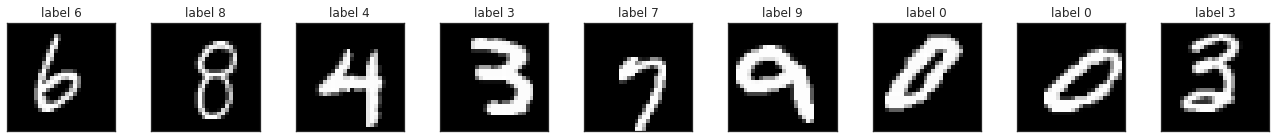

In [41]:
print(f"check left training images after omitting digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(left_train_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

check validation images after omitting digit 1


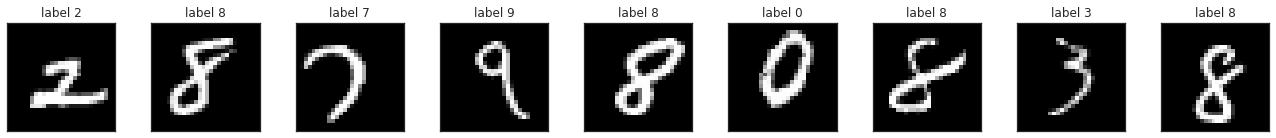

In [48]:
print(f"check validation images after omitting digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [23]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, valid_criterion, device)
            valid_losses.append(valid_loss)

            if epoch % print_every == (print_every - 1):
                acc_epochs.append(epoch)
                train_acc = get_accuracy(model, train_loader, device=device)
                train_accus.append(train_acc)
                valid_acc = get_accuracy(model, valid_loader, device=device)
                valid_accus.append(valid_acc)

                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      f'Train loss: {train_loss:.4f}\t'
                      f'Valid loss: {valid_loss:.4f}\t'
                      f'Train accuracy: {100 * train_acc:.2f}\t'
                      f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [24]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5):
        super(LeNet5, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.Dropout(p=dropout_ratio),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.Dropout(p=dropout_ratio),
        )

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

class StudentNet(nn.Module):

    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 1, 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(1, 2, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(32, 10),
        )
 
    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### Train Teacher Model

==========> Not find checkpoint, train
17:19:21 --- Epoch: 0	Train loss: 1.6744	Valid loss: 0.4959	Train accuracy: 90.04	Valid accuracy: 90.89
17:19:52 --- Epoch: 1	Train loss: 1.2302	Valid loss: 0.2631	Train accuracy: 94.49	Valid accuracy: 94.98
17:20:23 --- Epoch: 2	Train loss: 1.1392	Valid loss: 0.1842	Train accuracy: 95.53	Valid accuracy: 95.72
17:20:54 --- Epoch: 3	Train loss: 1.1016	Valid loss: 0.1494	Train accuracy: 96.20	Valid accuracy: 96.61
17:21:25 --- Epoch: 4	Train loss: 1.0637	Valid loss: 0.1343	Train accuracy: 96.42	Valid accuracy: 96.87
17:21:57 --- Epoch: 5	Train loss: 1.0501	Valid loss: 0.1146	Train accuracy: 97.02	Valid accuracy: 97.20
17:22:29 --- Epoch: 6	Train loss: 1.0483	Valid loss: 0.1115	Train accuracy: 96.94	Valid accuracy: 97.32
17:23:00 --- Epoch: 7	Train loss: 1.0300	Valid loss: 0.1073	Train accuracy: 97.22	Valid accuracy: 97.44
17:23:32 --- Epoch: 8	Train loss: 1.0194	Valid loss: 0.0971	Train accuracy: 97.16	Valid accuracy: 97.59
17:24:02 --- Epoch: 9	Tra

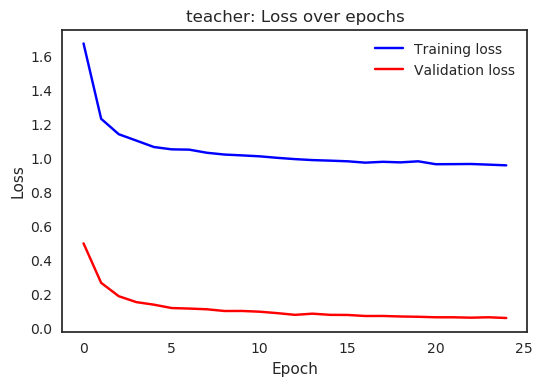

In [25]:
LeNet5_CHECKPOINT = "LeNet5_trained_parameters.pt"

model_teacher = LeNet5(N_CLASSES, DROPOUT).to(DEVICE)

if os.path.exists(LeNet5_CHECKPOINT):
    # load model Directly
    print("==========> Load Parameters")
    model_teacher.load_state_dict(torch.load(LeNet5_CHECKPOINT))

else:
    # If model not trained 
    print("==========> Not find checkpoint, train")

    LEARNING_RATE = 0.001
    N_EPOCHS = 25
    optimizer = torch.optim.Adam(model_teacher.parameters(), lr=LEARNING_RATE)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params)

    # Save model 
    torch.save(model_teacher.state_dict(), LeNet5_CHECKPOINT)

### Q4 Train Student Model

#### all digits: student model with ground truth labels

=======> Student trained on Ground Truth
17:36:36 --- Epoch: 0	Train loss: 0.9657	Valid loss: 0.3025	Train accuracy: 78.63	Valid accuracy: 94.19
17:37:00 --- Epoch: 1	Train loss: 0.6615	Valid loss: 0.3270	Train accuracy: 81.20	Valid accuracy: 94.01
17:37:24 --- Epoch: 2	Train loss: 0.6024	Valid loss: 0.2698	Train accuracy: 81.58	Valid accuracy: 94.80
17:37:48 --- Epoch: 3	Train loss: 0.5599	Valid loss: 0.2408	Train accuracy: 83.56	Valid accuracy: 94.89
17:38:12 --- Epoch: 4	Train loss: 0.5318	Valid loss: 0.2677	Train accuracy: 85.24	Valid accuracy: 94.10
17:38:37 --- Epoch: 5	Train loss: 0.4905	Valid loss: 0.1787	Train accuracy: 84.44	Valid accuracy: 96.65
17:39:01 --- Epoch: 6	Train loss: 0.4578	Valid loss: 0.2165	Train accuracy: 86.43	Valid accuracy: 96.48
17:39:25 --- Epoch: 7	Train loss: 0.4356	Valid loss: 0.1999	Train accuracy: 86.63	Valid accuracy: 96.39
17:39:50 --- Epoch: 8	Train loss: 0.4217	Valid loss: 0.2688	Train accuracy: 87.38	Valid accuracy: 94.71
17:40:14 --- Epoch: 9	T

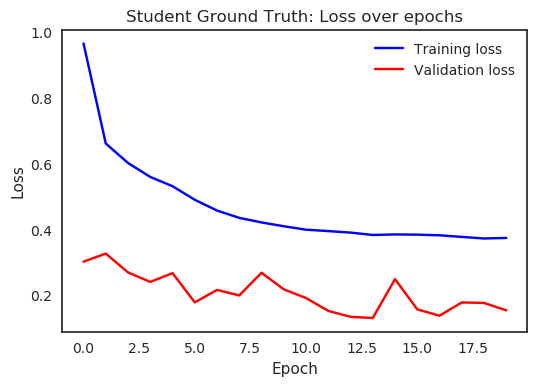

In [27]:
LEARNING_RATE = 0.01
N_EPOCHS = 20

print(f"=======> Student trained on Ground Truth")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

#### omitted digits: student model with ground truth labels

=======> Student trained on Ground Truth
17:44:27 --- Epoch: 0	Train loss: 2.2264	Valid loss: 4.7483	Train accuracy: 11.76	Valid accuracy: 0.00
17:44:35 --- Epoch: 1	Train loss: 2.2027	Valid loss: 5.6869	Train accuracy: 11.51	Valid accuracy: 0.00
17:44:45 --- Epoch: 2	Train loss: 2.1998	Valid loss: 6.3013	Train accuracy: 11.51	Valid accuracy: 0.00
17:44:54 --- Epoch: 3	Train loss: 2.1987	Valid loss: 6.7720	Train accuracy: 11.51	Valid accuracy: 0.00
17:45:03 --- Epoch: 4	Train loss: 2.1981	Valid loss: 7.1631	Train accuracy: 11.51	Valid accuracy: 0.00
17:45:11 --- Epoch: 5	Train loss: 2.1978	Valid loss: 7.5045	Train accuracy: 11.12	Valid accuracy: 0.00
17:45:20 --- Epoch: 6	Train loss: 2.1977	Valid loss: 7.8114	Train accuracy: 11.51	Valid accuracy: 0.00
17:45:29 --- Epoch: 7	Train loss: 2.1976	Valid loss: 8.0954	Train accuracy: 11.76	Valid accuracy: 0.00
17:45:37 --- Epoch: 8	Train loss: 2.1976	Valid loss: 8.3613	Train accuracy: 11.19	Valid accuracy: 0.00
17:45:46 --- Epoch: 9	Train loss

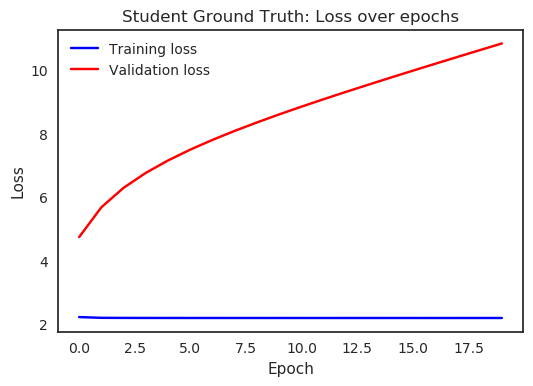

In [28]:
LEARNING_RATE = 0.01
N_EPOCHS = 20

print(f"=======> Student trained on Ground Truth")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, left_train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

#### all digits: student model with soft labels

In [29]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
T = 3
LEARNING_RATE = 0.01
N_EPOCHS = 20
ALPHA = 0.9

=======> Temperature: 3
17:47:42 --- Epoch: 0	Train loss: 4.1604	Valid loss: 0.1710	Train accuracy: 78.46	Valid accuracy: 96.30
17:48:08 --- Epoch: 1	Train loss: 2.5728	Valid loss: 0.1155	Train accuracy: 83.11	Valid accuracy: 97.36
17:48:35 --- Epoch: 2	Train loss: 2.2363	Valid loss: 0.1030	Train accuracy: 84.40	Valid accuracy: 97.80
17:49:01 --- Epoch: 3	Train loss: 2.0771	Valid loss: 0.1021	Train accuracy: 85.49	Valid accuracy: 97.97
17:49:27 --- Epoch: 4	Train loss: 1.9755	Valid loss: 0.0809	Train accuracy: 86.14	Valid accuracy: 98.33
17:49:55 --- Epoch: 5	Train loss: 1.9205	Valid loss: 0.0824	Train accuracy: 86.48	Valid accuracy: 98.15
17:50:22 --- Epoch: 6	Train loss: 1.8731	Valid loss: 0.0910	Train accuracy: 86.92	Valid accuracy: 97.97
17:50:49 --- Epoch: 7	Train loss: 1.8350	Valid loss: 0.1001	Train accuracy: 86.83	Valid accuracy: 97.89
17:51:15 --- Epoch: 8	Train loss: 1.8121	Valid loss: 0.0745	Train accuracy: 87.08	Valid accuracy: 98.33
17:51:42 --- Epoch: 9	Train loss: 1.7974

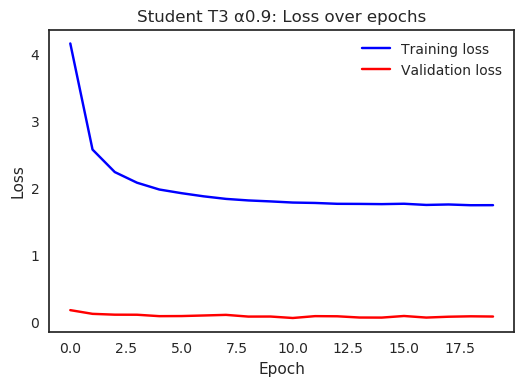

In [30]:
print(f"=======> Temperature: {T}")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(T, ALPHA)

prefix = f"student_T{T}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{T} α{ALPHA}"
     }

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  

#### omitted digits: student model with soft labels

=======> Soft label with omitted digits
17:56:19 --- Epoch: 0	Train loss: 3.6349	Valid loss: 5.4511	Train accuracy: 79.07	Valid accuracy: 0.00
17:56:31 --- Epoch: 1	Train loss: 2.5200	Valid loss: 5.5266	Train accuracy: 80.83	Valid accuracy: 0.00
17:56:42 --- Epoch: 2	Train loss: 2.3314	Valid loss: 6.6848	Train accuracy: 81.12	Valid accuracy: 0.00
17:56:53 --- Epoch: 3	Train loss: 2.2043	Valid loss: 5.5244	Train accuracy: 83.24	Valid accuracy: 0.00
17:57:05 --- Epoch: 4	Train loss: 2.1505	Valid loss: 6.0172	Train accuracy: 83.44	Valid accuracy: 0.00
17:57:17 --- Epoch: 5	Train loss: 2.1212	Valid loss: 5.5093	Train accuracy: 84.12	Valid accuracy: 0.00
17:57:28 --- Epoch: 6	Train loss: 2.0944	Valid loss: 6.4305	Train accuracy: 84.05	Valid accuracy: 0.00
17:57:39 --- Epoch: 7	Train loss: 2.0541	Valid loss: 5.8707	Train accuracy: 83.87	Valid accuracy: 0.00
17:57:50 --- Epoch: 8	Train loss: 2.0251	Valid loss: 5.9980	Train accuracy: 84.39	Valid accuracy: 0.00
17:58:01 --- Epoch: 9	Train loss:

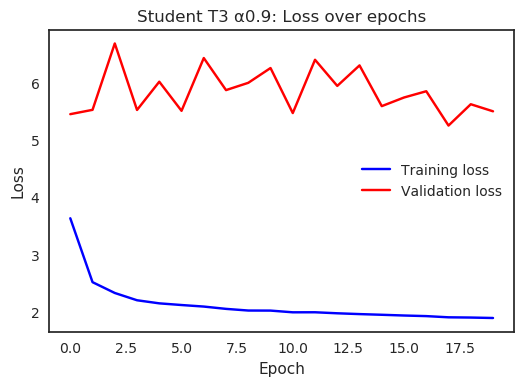

In [31]:
print("=======> Soft label with omitted digits")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(T, ALPHA)
prefix = f"student_T{T}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{T} α{ALPHA}"
     }

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, left_train_loader, omit_test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s.state_dict(), f"{dir_path}/{prefix}_parameters.pt")

print("=======> Soft label with omitted digits")

In [44]:
# add bias in the last layer
BIAS = 3.5
print(model_s.model)
model_s.model[-1].bias.data = model_s.model[-1].bias.data + BIAS

Sequential(
  (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=32, out_features=10, bias=True)
)


In [46]:
with torch.no_grad():
    model, valid_loss = validate(omit_test_loader, model_s, valid_criterion, DEVICE)
    valid_acc = get_accuracy(model_s, omit_test_loader, device=DEVICE)
    print(f"valid accuracy: {valid_acc}, valid loss: {valid_loss}")

valid accuracy: 0.0, valid loss: 5.500997037089344


In [36]:
model_s.model[-1].bias.data

tensor([-1.0426,  0.9601,  1.4297, -1.2688,  2.9203,  2.2367, -0.9661,  3.6615,
        -3.8560, -1.4804], device='cuda:0')

In [37]:
model_s.model[-1].bias.data + 3.5

tensor([ 2.4574,  4.4601,  4.9297,  2.2312,  6.4203,  5.7367,  2.5339,  7.1615,
        -0.3560,  2.0196], device='cuda:0')

In [ ]:
model_s.model[-1].bias.data = .model[-1].bias.data + 3.5